In [41]:
import joblib
import json
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from shapely.geometry import shape, Point

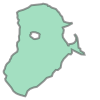

In [2]:
# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)
crystal_mountain_area = [site for site in ski_areas['features'] if site['properties']['name'] == 'Crystal Mountain'][0]
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_polygon

In [3]:
!aws s3 cp s3://aimees-snow-project/results.parquet .

download: s3://aimees-snow-project/results.parquet to ./results.parquet


In [4]:
# Load data
results_df = pd.read_parquet('results.parquet')
results_df = results_df.dropna(subset=['fsca'])
results_df['datetime'] = pd.to_datetime(results_df['time'])
results_df['day'] = results_df['datetime'].dt.day
results_df['month'] = results_df['datetime'].dt.month
results_df['year'] = results_df['datetime'].dt.year
results_df.loc[~results_df['fsca'].between(0, 1000), 'fsca'] = None
results_df.head()

,time,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca,datetime,day,month,year
0,2024-12-25T18:49:51.253821Z,-121.508679,46.922242,36261.0,35869,34486,34155,33048,17509,18436,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
1,2024-12-25T18:49:51.253821Z,-121.508679,46.921895,36219.0,35757,34552,34083,32874,17493,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
2,2024-12-25T18:49:51.253821Z,-121.508679,46.921547,36237.0,35765,34417,34086,32936,17457,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
3,2024-12-25T18:49:51.253821Z,-121.508679,46.921199,36219.0,35760,34536,34043,32889,17450,18471,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
4,2024-12-25T18:49:51.253821Z,-121.508331,46.923286,36363.0,35863,34542,34192,33038,17589,18608,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024


In [5]:
input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
x_input_data = results_df[input_columns]
x_scaled = X_scaler.transform(x_input_data)

In [6]:
%%time
y_pred = model.predict(x_scaled)
y_pred

CPU times: user 1min, sys: 3.66 s, total: 1min 4s
Wall time: 1min 4s


array([0.28870968, 0.29087558, 0.2924424 , ..., 0.08354839, 0.08737327,
       0.08737327], shape=(19957490,))

In [7]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
results_df['snow_depth_prediction'] = y_scaled
results_df.shape

(19957490, 16)

### Select max pixel per day

Reduce overlapping pixels by grouping data values by day, latitude, and longitude. Aggregate by the highest value for that pixel for that day. This only removes a small number of pixels.

In [8]:
max_by_day = results_df.groupby(['year', 'month', 'day', 'latitude', 'longitude']).agg({'snow_depth_prediction': 'max'}).reset_index(level=[3,4])
max_by_day.head()

latitude   longitude  snow_depth_prediction
year month day                                              
1982 11    20   46.909031 -121.498596              31.230000
           20   46.909031 -121.498249              32.420000
           20   46.909379 -121.498944              31.590000
           20   46.909379 -121.498596              27.480000
           20   46.909379 -121.498249              35.620001

### Check each day has pixels that cover the entire polygon

In [9]:
def check_daily_coverage(rows, target_polygon):
    # Create points from your DataFrame
    points = [Point(lon, lat) for lon, lat in zip(rows['longitude'], rows['latitude'])]

    # Check if all points are within the polygon
    points_in_polygon = [point.within(target_polygon) for point in points]
    coverage_percentage = sum(points_in_polygon) / len(points_in_polygon) * 100
    return coverage_percentage

In [10]:
%%time
for daily_index in max_by_day.index.unique():
    rows = max_by_day.loc[daily_index]
    coverage_percentage = check_daily_coverage(rows, crystal_polygon)
    if coverage_percentage < 99:
        print(f"Day {daily_index} has {coverage_percentage}% coverage")
        # remove from group if <99% coverage

CPU times: user 2min 44s, sys: 588 ms, total: 2min 45s
Wall time: 2min 44s


### Calculate and add snow volume

In [11]:
# what we have a matrix of observations, identified by datetime and a snow depth prediction for each pixel.
# We can multiply those by the size of each pixel to get the area of snow.
# Then we can sum those up to get the total area of snow for each year.
area_of_each_pixel = 30 * 30
max_by_day['snow_volume_prediction'] = max_by_day['snow_depth_prediction'] * area_of_each_pixel

### Group data values by latitude, longitude and month

And calculate the average snow volume for each pixel,

In [12]:
avg_pixel_month = max_by_day.groupby(['year', 'month', 'latitude', 'longitude']).agg({'snow_volume_prediction': 'mean'})
avg_pixel_month = avg_pixel_month.reset_index()

In [49]:
# %%time
# avg_pixel_month['date'] = pd.to_datetime(avg_pixel_month.assign(day=1)[['year', 'month', 'day']])

# # Create animated scatter 
# fig = px.scatter_map(
#     avg_pixel_month, 
#     lat="latitude", 
#     lon="longitude",
#     color="snow_volume_prediction",
#     animation_frame="date",
#     hover_data=["snow_volume_prediction"],
#     color_continuous_scale="Viridis",
#     size_max=15,
#     zoom=11,
#     range_color=[20e3, 140e3]
# )

# fig.update_layout(
#     title="Time-series Map of snow_volume_prediction",
#     height=600
# )

# fig.show()

### Calculate the monthly average across the daily max volume

In [37]:
avg_region_month = avg_pixel_month.groupby(['year', 'month']).agg({'snow_volume_prediction': 'mean'})
avg_region_month

snow_volume_prediction
year month                        
1982 11               30366.003259
     12               50726.237638
1983 1                90572.747016
1984 4               112268.872885
     5                94046.402831
...                            ...
2024 8                   48.736448
     9                  234.819105
     10                 803.361136
     11               18664.066534
     12               45769.745886

[473 rows x 1 columns]

### Calculate the sum for each season

In [38]:
def get_snow_season(month, year):
    """Convert month/year to snow season year"""
    if month >= 11:  # Nov, Dec
        return f"{int(year)}-{int(year)+1}"  # Snow season starts this year
    elif month <= 4:  # Jan, Feb, Mar, Apr
        return f"{int(year)-1}-{int(year)}"  # Snow season started previous year
    else:
        return None  # Not in snow season (May-Oct)

# Apply to your DataFrame
avg_region_month = avg_region_month.reset_index()  # Convert index to columns temporarily
avg_region_month['snow_season'] = avg_region_month.apply(lambda row: get_snow_season(row['month'], row['year']), axis=1)

# Filter to only snow season months and group
snow_season_data = avg_region_month[avg_region_month['snow_season'].notna()]
grouped = snow_season_data.groupby('snow_season')

In [39]:
filter_incomplete_seasons = grouped.filter(lambda group: len(group) == 6, dropna=True)
sum_by_season = filter_incomplete_seasons.groupby('snow_season').agg({'snow_volume_prediction': 'sum'})
sum_by_season

,snow_volume_prediction
snow_season,
1984-1985,502157.142767
1986-1987,495767.160171
1992-1993,502550.266017
1993-1994,479801.537025
1994-1995,495645.904158
1995-1996,490255.361354
1996-1997,499900.060037
1997-1998,500109.710127
1998-1999,511245.825333


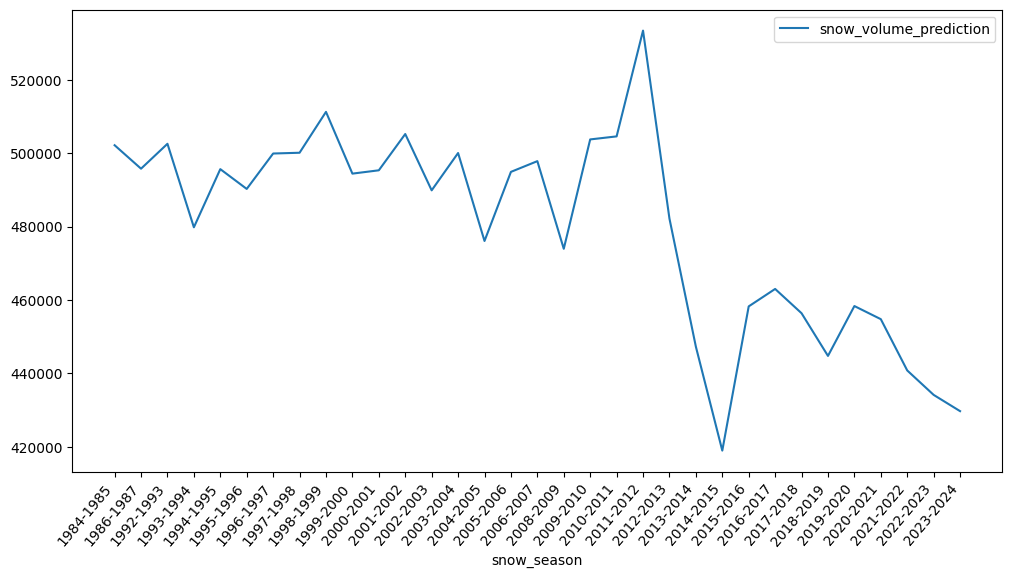

In [47]:
# Plot and set all indices as xticks
ax = sum_by_season.plot(figsize=(12,6))
ax.set_xticks(range(len(sum_by_season.index)))
ax.set_xticklabels(sum_by_season.index)
plt.xticks(rotation=50, ha='right')
plt.show()